# Subsurface Machine Learning Final Project: Well Log Classification

The objective of this project is to build two machine learning models:
- a Decision Tree Classifier (discussed in class)
- a Random Forest Classifier (a new model)

and to compare their effectiveness.

These two models will be trained/tested on facies logs from nine wells in the Panoma field located in Southwest Kansas.  
[Here](https://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) is a link to the study for which the data was collected  
[Here](https://www.kaggle.com/datasets/imeintanis/well-log-facies-dataset) is a link to the kaggle post of this dataset  

# Imports  
Here are the imports for this notebook

In [1]:
import pandas as pd # to read the dataset
import numpy as np # general use
import matplotlib.pyplot as plt # for visualization
from matplotlib.colors import ListedColormap, BoundaryNorm # visualization
import seaborn as sns # also for visualizations
from sklearn.ensemble import RandomForestClassifier # random forest 
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.metrics import classification_report # to measure the effectiveness of the models
from sklearn.model_selection import GridSearchCV, train_test_split # hyperparameter tuning/test train split
import ipywidgets as widgets # to make interactive visualizations

# Data Analysis

Here I read the dataset from the github repository for this project

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/naoufaliennadi/smlfinalproject/refs/heads/main/facies_data.csv")
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


**Here are the descriptions given in the kaggle post:**

The seven variables are:

- GR: this wireline logging tools measure gamma emission
- ILD_log10: this is resistivity measurement
- PE: photoelectric effect log
- DeltaPHI: Phi is a porosity index in petrophysics.
- PNHIND: Average of neutron and density log.
- NM_M: nonmarine-marine indicator
- RELPOS: relative position

The nine discrete facies (classes of rocks) are:

- SS: Nonmarine sandstone
- CSiS: Nonmarine coarse siltstone
- FSiS: Nonmarine fine siltstone
- SiSH: Marine siltstone and shale
- MS: Mudstone (limestone)
- WS: Wackestone (limestone)
- D: Dolomite
- PS: Packstone-grainstone (limestone)
- BS: Phylloid-algal bafflestone (limestone)

**Here is what I'm assuming:**

The Facies variable corresponds to the facie, for example 3 would be FSiS  
The Well Name/Formation Variables contain the given name of the wells/formations the wells are from  
Depth is just the measured depth of each log measurement, and for each well, the RELPOS would equal 1 at shallowest depth and decrease from there

**Data Quality**

In [3]:
for column in df.columns:
    print(column+" :", len(df[column].dropna()))
df.describe().transpose()

Facies : 3232
Formation : 3232
Well Name : 3232
Depth : 3232
GR : 3232
ILD_log10 : 3232
DeltaPHI : 3232
PHIND : 3232
PE : 3232
NM_M : 3232
RELPOS : 3232


,count,mean,std,min,25%,50%,75%,max
Facies,3232.0,4.422030,2.504243,1.000000,2.00000,4.000000,6.000000,9.000
Depth,3232.0,2875.824567,131.006274,2573.500000,2791.00000,2893.500000,2980.000000,3122.500
GR,3232.0,66.135769,30.854826,13.250000,46.91875,65.721500,79.626250,361.150
ILD_log10,3232.0,0.642719,0.241845,-0.025949,0.49275,0.624437,0.812735,1.480
DeltaPHI,3232.0,3.559642,5.228948,-21.832000,1.16375,3.500000,6.432500,18.600
PHIND,3232.0,13.483213,7.698980,0.550000,8.34675,12.150000,16.453750,84.400
PE,3232.0,3.725014,0.896152,0.200000,3.10000,3.551500,4.300000,8.094
NM_M,3232.0,1.498453,0.500075,1.000000,1.00000,1.000000,2.000000,2.000
RELPOS,3232.0,0.520287,0.286792,0.010000,0.27300,0.526000,0.767250,1.000


There are no missing values in this dataset, therefore no imputing will be necessary

Here I add a new column FaciesName, which has the abbreviated label name corresponding to the Facies value  
This will help make some of the future vizualizations clearer

In [4]:
facies = {
        "SS": 1,
        "CSiS": 2,
        "FSiS": 3,
        "SiSH": 4,
        "MS": 5,
        "WS": 6,
        "D": 7,
        "PS": 8,
        "BS": 9,
}
inv_facies = {v: k for k, v in facies.items()}
df["FaciesName"] = df["Facies"].map(inv_facies)
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesName
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


# Feature Engineering  
From my knowledge of my Formation Evaluation class, three features I wanted to engineer were:
- the difference between the Density and Neutron porosity logs
    - For example, this is a very easy way to detect shale, as this difference is usually negative when shale is present
- the relative position of the datapoints
    - cycles often appear in rock deposition patterns, you can often notice these cycles and make good inferences based on their appearance
- the relative gamma ray of the datapoints
    - sometimes, there is a significant amount of clay everywhere, so the relative gamma ray becomes more telling than its raw value  

The first two were already implemented in the dataset (as "DeltaPHI" and "RELPOS"), so I just have to make a new column RELGR for the relative gamma ray

In [5]:
df["RELGR"] = df.groupby("Well Name")["GR"].transform(lambda x: x/x.max())

Something else to note is that this dataset has 9 different facies, with only 3232 entries.

In [6]:
for i in df["FaciesName"].unique():
    print(i+" :",len(df[df["FaciesName"]==i]))

FSiS : 615
CSiS : 738
PS : 498
WS : 462
D : 98
SiSH : 184
MS : 217
BS : 161
SS : 259


Since many of these facies describe the same type of rock (4 facies describe limestones and 2 describe nonmarine siltstones), I want to see if any of these labels could be combined together.
Combining them together should improve the accuracy of the models, as if for example, all 4 limestones could be combined into one, the models wouldn't make mistakes between Wackestones and Mudstones as it would simply label both as limestone.
  
This cross plot shows the 5 geological properties from the well logs (gamma ray, resistivity, average neutron/density porosity, porosity difference, and photoelectric factor) and using the drop downs I can compared different facies to each other.

In [7]:
def plot(fac1,fac2):
    g = sns.pairplot(df[df["FaciesName"].isin([fac1,fac2])],vars = ["GR","ILD_log10","DeltaPHI","PHIND","PE"],hue="FaciesName")
    g.map_lower(sns.kdeplot, levels=1, color=".2")

widgets.interact(plot, 
                 fac1 = widgets.Dropdown(options=df["FaciesName"].unique(),value="SS",description="Facies 1:"),
                 fac2 = widgets.Dropdown(options=df["FaciesName"].unique(),description="Facies 2:")
                 )

interactive(children=(Dropdown(description='Facies 1:', index=8, options=('FSiS', 'CSiS', 'PS', 'WS', 'D', 'Si…

<function __main__.plot(fac1, fac2)>

Using that, I see a couple of facies that show minimal differences in their distributions:
- CSiS and FSiS
- MS and WS and PS  
Therefore I will combine the first two into SiS and the second three into GLS

In [8]:
df["Facies"] = np.where(df["Facies"]==3,2,df["Facies"])
df["FaciesName"] = np.where(df["FaciesName"]=="CSiS","SiS",df["FaciesName"])
df["FaciesName"] = np.where(df["FaciesName"]=="FSiS","SiS",df["FaciesName"])

df["Facies"] = np.where(df["Facies"]==6,5,df["Facies"])
df["Facies"] = np.where(df["Facies"]==8,5,df["Facies"])
df["FaciesName"] = np.where(df["FaciesName"]=="MS","GLS",df["FaciesName"])
df["FaciesName"] = np.where(df["FaciesName"]=="WS","GLS",df["FaciesName"])
df["FaciesName"] = np.where(df["FaciesName"]=="PS","GLS",df["FaciesName"])

#mapping the Facies values from 1 - 9 to 0-5 to make future visulizations easier
map = {1:0,2:1,4:2,5:3,7:4,9:5}
df["Facies"] = df["Facies"].replace(map)

print(df["Facies"].unique())
print(df["FaciesName"].unique())


[1 3 4 2 5 0]
['SiS' 'GLS' 'D' 'SiSH' 'BS' 'SS']


# Data Preprocessing  
Before making the models, I will make x and y datasets of the relevant values, and standardize all the values

In [9]:
labels = df["Facies"].values
features = df.drop(["Facies","FaciesName","Well Name", "Formation", "Depth"], axis = 1)
features = ((features-features.mean())/features.std()).values

Then, make a test and train split of 20/80

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size=.2, random_state=252)

# Training the Models  
for each model, i will use a grid search over 5-fold cross validations to hopefully get the best hyperparameters for each model

# Decision Tree Model

In [11]:
params = {
    "criterion":["gini", "entropy", "log_loss"],
    "splitter":["best","random"],
    "min_samples_split":[i for i in range(2,5)],
    "max_features":[None,"log2","sqrt"]
}
gcv = GridSearchCV(DecisionTreeClassifier(),param_grid=params,cv=5,n_jobs=-1).fit(features,labels)
gcv.best_params_

{'criterion': 'gini',
 'max_features': None,
 'min_samples_split': 2,
 'splitter': 'best'}

In [12]:
model = DecisionTreeClassifier(**gcv.best_params_,random_state=252)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
print(classification_report(ytest,ypred,  target_names=['SS','SiS' ,'SiSH' ,'GLS', 'D', 'BS']))

              precision    recall  f1-score   support

          SS       0.70      0.72      0.71        46
         SiS       0.92      0.92      0.92       287
        SiSH       0.59      0.48      0.53        42
         GLS       0.84      0.88      0.86       229
           D       0.82      0.64      0.72        14
          BS       0.83      0.83      0.83        29

    accuracy                           0.85       647
   macro avg       0.78      0.74      0.76       647
weighted avg       0.85      0.85      0.85       647



# Random Forest Model

In [13]:
params2 = {
    "n_estimators":[100*i for i in range(1,4)],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_split":[i for i in range(2,4)],
    "max_features":[None,"log2","sqrt"]
}
gcv2 = GridSearchCV(RandomForestClassifier(),param_grid=params2,cv=5,n_jobs=-1).fit(features,labels)
gcv2.best_params_

{'criterion': 'log_loss',
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'n_estimators': 300}

In [14]:
model2 = RandomForestClassifier(**gcv2.best_params_,random_state=564)
model2.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)
print(classification_report(ytest,ypred2,  target_names=['SS','SiS' ,'SiSH' ,'GLS', 'D', 'BS']))

              precision    recall  f1-score   support

          SS       0.89      0.72      0.80        46
         SiS       0.93      0.97      0.95       287
        SiSH       0.94      0.40      0.57        42
         GLS       0.84      0.97      0.90       229
           D       1.00      0.36      0.53        14
          BS       1.00      0.86      0.93        29

    accuracy                           0.90       647
   macro avg       0.94      0.71      0.78       647
weighted avg       0.90      0.90      0.89       647



# Results  
As expected, random forest performs better than decision tree as a classifier model on every metric.  
There could be a plethora of reasons for this, but my best guess for this scenario is that this dataset has so many predictive features that random forest's method of using many trees most likely handles this multidimensional data set better than one singular decision tree

# Plotting Results  
Let's plot the different models predictions and compare them to the real data for the NOLAN well

Here is the plotting function

In [15]:
def plotwell(name,depth,facies):
    facies_labels = ['SS','SiS' ,'SiSH' ,'GLS', 'D', 'BS']
    facies_colors = ['gold', 'orange', 'green', 'grey', 'cyan',"pink"]

    cmap = ListedColormap(facies_colors)
    norm = BoundaryNorm(boundaries=np.arange(len(facies_labels) + 1) - 0.5, ncolors=len(facies_labels))

    fig, ax = plt.subplots(figsize=(3, 8))
    img = ax.imshow(facies.values.reshape(-1,1), aspect='auto', cmap=cmap, norm=norm, extent=[0, 1, depth.max(), depth.min()])

    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.1, pad=0.02)
    cbar.set_ticks(np.arange(len(facies_labels)))
    cbar.set_ticklabels(facies_labels)
    ax.set_xticks([])
    ax.set_ylabel('Depth (m)')
    ax.set_title(name+' Facies')

    plt.tight_layout()
    plt.show()

Plotting the real values

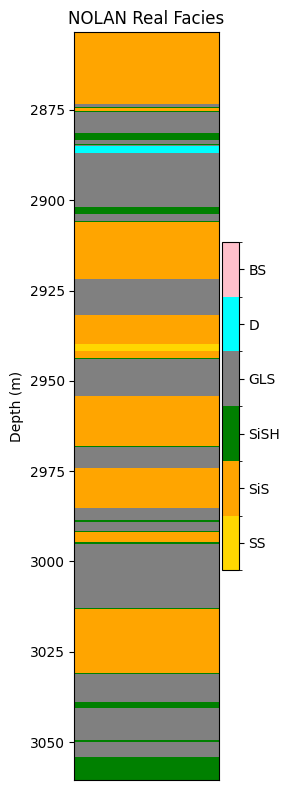

In [16]:
plotwell("NOLAN Real",df["Depth"][df["Well Name"]=="NOLAN"],df["Facies"][df["Well Name"]=="NOLAN"])

Plotting the Decision Tree prediction

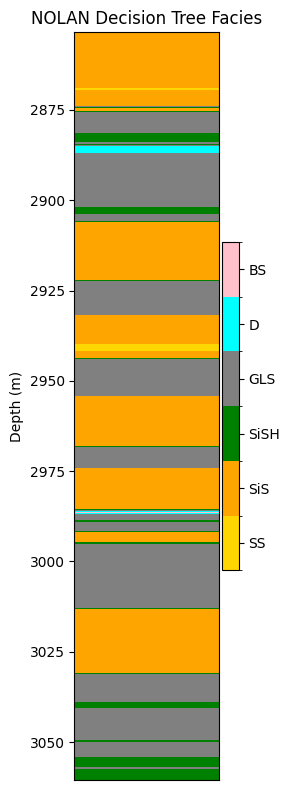

In [17]:
dtdf = pd.DataFrame(features).join(pd.DataFrame({"Facies":model.predict(features)})).join(df[["Well Name","Depth"]])
plotwell("NOLAN Decision Tree",dtdf["Depth"][dtdf["Well Name"]=="NOLAN"],dtdf["Facies"][dtdf["Well Name"]=="NOLAN"])

Plotting the Random Forest prediction

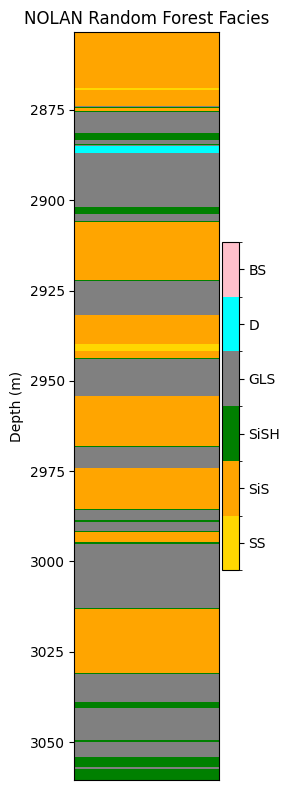

In [18]:
rfdf = pd.DataFrame(features).join(pd.DataFrame({"Facies":model2.predict(features)})).join(df[["Well Name","Depth"]])
plotwell("NOLAN Random Forest",rfdf["Depth"][rfdf["Well Name"]=="NOLAN"],rfdf["Facies"][rfdf["Well Name"]=="NOLAN"])

# Conclusion
Random forest is basically a better version of the decision tree model, as it simply employs more of them to get a more accurate result, playing to the bias-variance tradeoff  
However, the overall improvement wasn't that large, however this could just be a result of the dataset, as it was extremely well made.  
In theory, with a more noisy dataset for example, the gap between the two would only get wider (in favor of random forest) as one of the main weaknesses of a lone decision tree is its sensitivity to noise/outliers.

By Naoufal Ennadi